In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xnli-data/xnli/dev.tsv
/kaggle/input/xnli-data/xnli/train.tsv
/kaggle/input/xnli-data/xnli/test.tsv
/kaggle/input/contradictory-my-dear-watson/test.csv
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv


In [65]:
os.environ["WANDB_API_KEY"] = "0" 

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer,TFAutoModel

In [67]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [68]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

In [69]:
!pip install nlp
import nlp

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [70]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


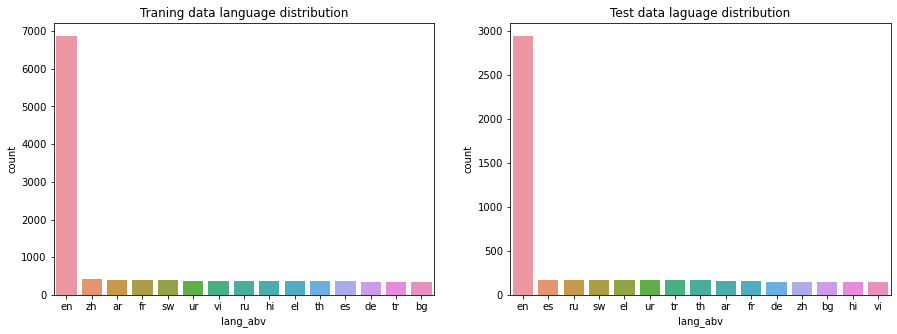

In [71]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Traning data language distribution')
sns.countplot(data = train, x = 'lang_abv', order = train['lang_abv'].value_counts().index)

plt.subplot(1,2,2)
plt.title('Test data laguage distribution')
sns.countplot(data = test, x = 'lang_abv', order = test['lang_abv'].value_counts().index);

In [72]:
train["lang_abv"].value_counts()

en    6870
zh     411
ar     401
fr     390
sw     385
ur     381
vi     379
ru     376
hi     374
el     372
th     371
es     366
de     351
tr     351
bg     342
Name: lang_abv, dtype: int64

Have a feeling we're doing upsampling here.

In [73]:
train = train[['premise', 'hypothesis', 'label', 'language']]

In [74]:
train

,premise,hypothesis,label,language
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,English
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,English
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,0,French
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,English
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,1,Thai
...,...,...,...,...
12115,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,2,English
12116,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,0,English
12117,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",2,English
12118,At the west end is a detailed model of the who...,The model temple complex is at the east end.,2,English


In [75]:
xnli = nlp.load_dataset(path='xnli')

In [76]:
xnli

{'test': Dataset(features: {'premise': Translation(languages=['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], id=None), 'hypothesis': TranslationVariableLanguages(languages=['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], num_languages=15, id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None)}, num_rows: 5010),
 'validation': Dataset(features: {'premise': Translation(languages=['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], id=None), 'hypothesis': TranslationVariableLanguages(languages=['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], num_languages=15, id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None)}, num_rows: 2490)}

In [77]:
# integrating user forwet's code. props to him!

buff = {}
buff["premise"] = []
buff["hypothesis"] = []
buff["label"] = []
buff["language"] = []

In [78]:
# Making a set to map our dataset language abbreviations to 
# their complete names.
uniq_lang = set()
for e in xnli["validation"]:
  for i in e["hypothesis"]["language"]:
    uniq_lang.add(i)

# Creating a dict that maps abv to their complete names. 
language_map = {}

# Taken test_csv just to use lang_abv column and nothing else.
for e in uniq_lang:
  language_map[e] = test.loc[test.lang_abv==e, "language"].iloc[0]

# Prepairing the dataset with the required columns.
for x in xnli['test']:
    label = x['label']
    for idx, lang in enumerate(x['hypothesis']['language']):
        
        # Skipping english samples as we don't want to upsample the samples
        # corresponding to english language.
        if lang=="en":
            continue
            
        hypothesis = x['hypothesis']['translation'][idx]
        premise = x['premise'][lang]
        buff['premise'].append(premise)
        buff['hypothesis'].append(hypothesis)
        buff['label'].append(label)
        buff['language'].append(language_map[lang])

# A pandas DataFrame for the prepared dataset.
xnli_df = pd.DataFrame(buff)

In [79]:
# index = []
# premise = []
# hypothesis = []
# label = []

# for example in xnli['validation']:
#     premise.append(example['premise'])
#     hypothesis.append(example['hypothesis'])
#     label.append(example['label'])

# xnli_df = pd.DataFrame(data={
#     'premise': premise,
#     'hypothesis': hypothesis,
#     'label': label
# })

xnli_df.head()

,premise,hypothesis,label,language
0,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,لم أتحدث معه مرة أخرى.,2,Arabic
1,"Е, аз дори не мислех за това, но бях толкова р...",Повече не съм говорил с него.,2,Bulgarian
2,"Nun, daran dachte ich nicht einmal, aber ich w...",Ich habe nicht wieder mit ihm gesprochen.,2,German
3,"Λοιπόν, δεν το σκέφτηκα καν, αλλά ήμουν τόσο α...",Δεν του μίλησα ξανά.,2,Greek
4,"Bien, ni estaba pensando en eso, pero estaba t...",No he vuelto a hablar con él.,2,Spanish


In [80]:
xnli_df.label.value_counts()

2    23380
1    23380
0    23380
Name: label, dtype: int64

In [81]:
# xnli_df = [['premise', 'hypothesis', 'label']]
xnli_df.duplicated().sum()

0

In [82]:
# Drop -1 labels. Simple cleaning. open this up if its mnli.
# mnli_df.drop(mnli_df.loc[mnli_df['label']==-1].index, inplace=True)

In [83]:
train_data = pd.concat([train, xnli_df])

In [84]:
train_data.language.value_counts()

English       6870
Chinese       5421
Arabic        5411
French        5400
Swahili       5395
Urdu          5391
Vietnamese    5389
Russian       5386
Hindi         5384
Greek         5382
Thai          5381
Spanish       5376
German        5361
Turkish       5361
Bulgarian     5352
Name: language, dtype: int64

In [85]:
train_data.isna().sum()

premise       0
hypothesis    0
label         0
language      0
dtype: int64

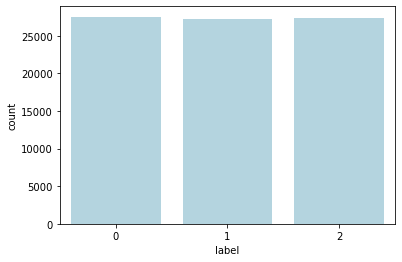

In [86]:
# check label counts.
import seaborn as sns
sns.countplot(train_data.label, color='lightblue');

In [87]:
# Where the magic happens for hyper parameter tweaking.
model_base="jplu/tf-xlm-roberta-large"
max_len=120
batch_size = 32 * strategy.num_replicas_in_sync
auto = tf.data.experimental.AUTOTUNE
epochs= 10
n_steps = len(train_data) // batch_size

In [88]:
# Where the magic happens for model tweaking.
def model_baseline(strategy,transformer):
    with strategy.scope():
        transformer_encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(max_len,), dtype=tf.int32, name="input_layer")
        sequence_output = transformer_encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(3, activation='softmax')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [89]:
model = model_baseline(strategy,model_base)

In [90]:
# We're using the new merged train data and using it against original test data.
train_text = train_data[['premise', 'hypothesis']].values.tolist()
test_text = test[['premise', 'hypothesis']].values.tolist()

In [91]:
# train_text

In [92]:
tokenizer = AutoTokenizer.from_pretrained(model_base)

In [93]:
train_encoded=tokenizer.batch_encode_plus(train_text,pad_to_max_length=True,max_length=max_len, truncation=True)
test_encoded=tokenizer.batch_encode_plus(test_text,pad_to_max_length=True,max_length=max_len, truncation=True)

In [94]:
# Train Test Split

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    train_encoded['input_ids'], 
    train_data.label.values, 
    test_size=0.1, 
    random_state=420
)

In [95]:
x_test = test_encoded['input_ids']

In [96]:
# Pipeline

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(batch_size).prefetch(auto))

valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size).cache().prefetch(auto))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size))

In [ ]:
lr_callback = get_lr_callback(batch_size)
checkpoint = tf.keras.callbacks.ModelCheckpoint("XLM-R-base.h5", save_weights_only=True,
                                                save_best_only=True, save_freq="epoch", monitor="val_loss",
                                                mode="min")

In [97]:
model.fit(train_dataset,steps_per_epoch=n_steps,validation_data=valid_dataset,epochs=epochs, callbacks=[lr_callback, checkpoint])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


321/321 [==============================] - 160s 499ms/step - accuracy: 0.3720 - loss: 1.1417 - val_accuracy: 0.5103 - val_loss: 1.0161
Epoch 2/10
321/321 [==============================] - 129s 403ms/step - accuracy: 0.7136 - loss: 0.6715 - val_accuracy: 0.8383 - val_loss: 0.4252
Epoch 3/10
321/321 [==============================] - 130s 405ms/step - accuracy: 0.8536 - loss: 0.3859 - val_accuracy: 0.8963 - val_loss: 0.2859
Epoch 4/10
321/321 [==============================] - 130s 405ms/step - accuracy: 0.9098 - loss: 0.2509 - val_accuracy: 0.9121 - val_loss: 0.2795
Epoch 5/10
321/321 [==============================] - 130s 406ms/step - accuracy: 0.9410 - loss: 0.1677 - val_accuracy: 0.9279 - val_loss: 0.2520
Epoch 6/10
321/321 [==============================] - 130s 406ms/step - accuracy: 0.9604 - loss: 0.1148 - val_accuracy: 0.9359 - val_loss: 0.2386
Epoch 7/10
321/321 [==============================] - 132s 412ms/step - accuracy: 0.9692 - loss: 0.0873 - val_accuracy: 0.9406 - val_lo

In [98]:
submission = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')

In [99]:
test_preds = model.predict(test_dataset, verbose=1)
submission['prediction'] = test_preds.argmax(axis=1)

21/21 [==============================] - 12s 556ms/step


In [100]:
submission.to_csv("submission.csv",index= False)

Things to experiment on with others. snli, enli, anli, multi_nli_mismatch, multi_nli, esnli, xnli

* MNLI with base code at acc 93% loss < 20%. val acc 89%. val loss 40% no tweaks. max length 84. batch size 32 * strat. 
* Multi_NLI with base used validation dataset. 97 acc < 15% tweaked at 87.73 val acc 44%+ val loss. batch size 32 * strat.
* XNLI Base. 98% accuracy less than 15 loss. 94% val accuracy 28% loss but 86% score in competition.
* XNLI with callbacks and increase max length, truncation=True. ->

Both MNLI seem to have same pattern of overfitting.

In [101]:
# save weights
# model.save_weights(f"XLMR_{VALIDATION}_ep{EPOCHS}.h5")

# hist = history.history
# print(max(hist['val_accuracy']))
# px.line(
#     hist, x=range(1, len(hist['loss'])+1), y=['accuracy', 'val_accuracy'], 
#     title='Model Accuracy', labels={'x': 'Epoch', 'value': 'Accuracy'}